In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import cv2
import os
import kagglehub

In [4]:
def dct(block):
    return cv2.dct(np.float32(block))

def idct(block):
    return cv2.idct(np.float32(block))

In [5]:
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freqs):
    heap = [Node(sym, f) for sym, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.freq + n2.freq)
        merged.left, merged.right = n1, n2
        heapq.heappush(heap, merged)
    return heap[0]

def make_codes(node, prefix="", codebook={}):
    if node is None:
        return
    if node.symbol is not None:
        codebook[node.symbol] = prefix
    make_codes(node.left, prefix + "0", codebook)
    make_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    freqs = Counter(data)
    tree = build_huffman_tree(freqs)
    codes = make_codes(tree, "", {})
    encoded = "".join([codes[val] for val in data])
    return encoded, codes

In [6]:
def compress_image(img_path):

    img = cv2.imread(img_path)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    Y_shifted = np.float32(Y) - 128
    dct_Y = dct(Y_shifted)
    Q = np.ones_like(dct_Y) * 20
    quantized = np.round(dct_Y / Q)
    flat = quantized.flatten().astype(int).tolist()
    encoded, codes = huffman_encode(flat)
    comp_size = len(encoded) / 8
    dequantized = quantized * Q
    rec_Y = idct(dequantized) + 128
    rec_Y = np.clip(rec_Y, 0, 255).astype(np.uint8)
    rec_img_ycrcb = cv2.merge([rec_Y, Cr, Cb])
    rec_img = cv2.cvtColor(rec_img_ycrcb, cv2.COLOR_YCrCb2BGR)
    orig_size = Y.size
    ratio = orig_size / comp_size
    return ratio, rec_img, orig_size, comp_size

In [7]:
def build_huffman_tree(freqs):
    heap = [Node(sym, f) for sym, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.freq + n2.freq)
        merged.left, merged.right = n1, n2
        heapq.heappush(heap, merged)
    return heap[0]

In [8]:
def load_dataset():
    dataset_path = kagglehub.dataset_download("kshitij192/cars-image-dataset")
    print("Dataset downloaded at:", dataset_path)
    return dataset_path

In [9]:
def display_dataset_results(dataset_path, start_index=0, end_index=10):
    all_images = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                all_images.append(os.path.join(root, file))
    all_images.sort()
    total = len(all_images)
    print(f"Total images found: {total}")
    start_index = max(0, start_index)
    end_index = min(end_index, total)
    if start_index >= end_index:
        print("Invalid range. No images to display.")
        return
    print(f"Displaying images from {start_index} to {end_index - 1}...\n")
    for idx in range(start_index, end_index):
        img_path = all_images[idx]
        file = os.path.basename(img_path)
        try:

            orig = cv2.imread(img_path)
            orig = cv2.resize(orig, (256, 256))

            ycbcr_img = cv2.cvtColor(orig, cv2.COLOR_BGR2YCrCb)

            ratio, recon_bgr, orig_size, comp_size = compress_image(img_path)

            recon_bgr = cv2.resize(recon_bgr, (256, 256))

            print(f"Original size (bytes): {orig_size}")
            print(f"Compressed size (bytes): {comp_size:.2f}")
            print(f"Compression Ratio: {ratio:.2f}")

            plt.figure(figsize=(12, 4))
            plt.suptitle(f"{file}\nOriginal: {orig_size / 1024:.2f} KB | Compressed: {comp_size / 1024:.2f} KB")
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
            plt.title("Original")
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(ycbcr_img, cv2.COLOR_YCrCb2RGB))
            plt.title("YCbCr")
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(recon_bgr, cv2.COLOR_BGR2RGB))
            plt.title("Compressed")
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"Error processing {file}: {e}")

100%|██████████| 36.3M/36.3M [00:04<00:00, 8.02MB/s]

Extracting files...


Dataset downloaded at: C:\Users\shree\.cache\kagglehub\datasets\kshitij192\cars-image-dataset\versions\3
Total images found: 4165
Displaying images from 1 to 7...

Original size (bytes): 50508
Compressed size (bytes): 14922.62
Compression Ratio: 3.38


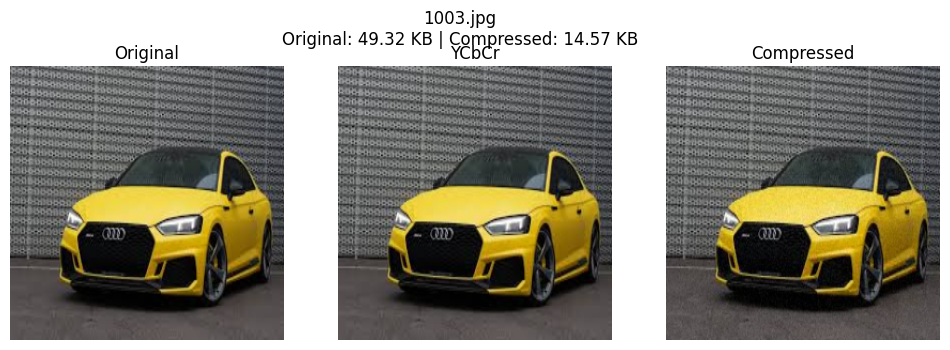

Original size (bytes): 50325
Compressed size (bytes): 12378.62
Compression Ratio: 4.07


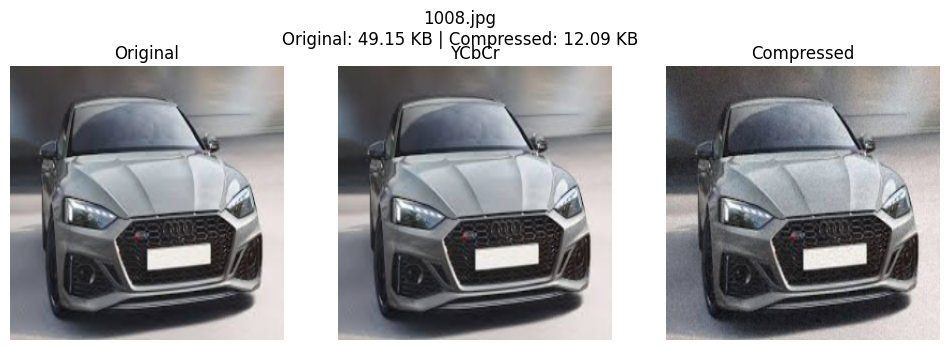

Original size (bytes): 50325
Compressed size (bytes): 11178.50
Compression Ratio: 4.50


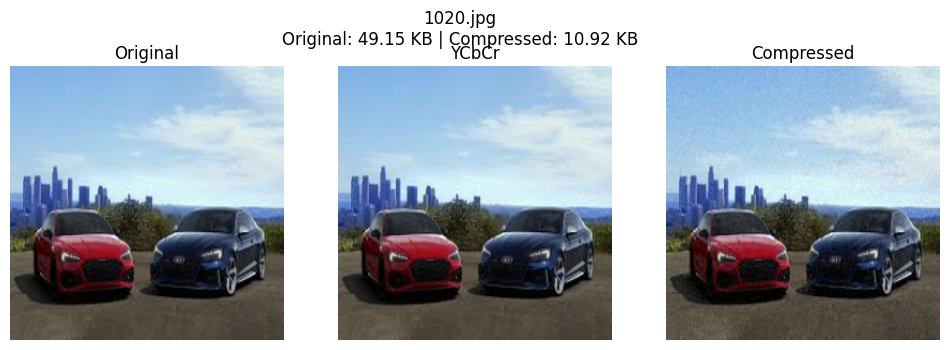

Original size (bytes): 50625
Compressed size (bytes): 15129.38
Compression Ratio: 3.35


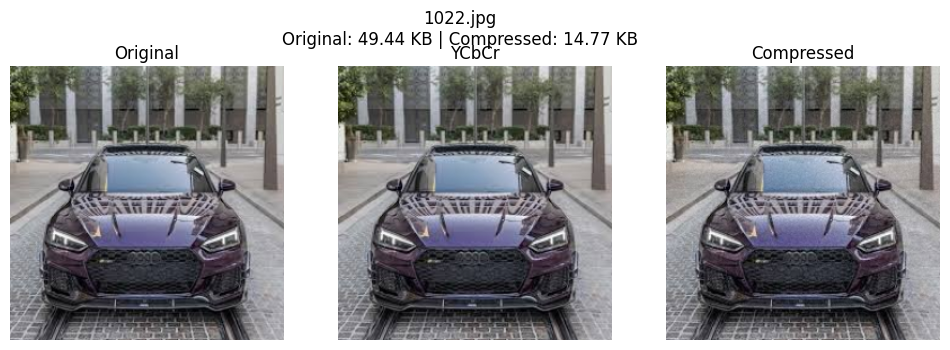

Original size (bytes): 50400
Compressed size (bytes): 14799.38
Compression Ratio: 3.41


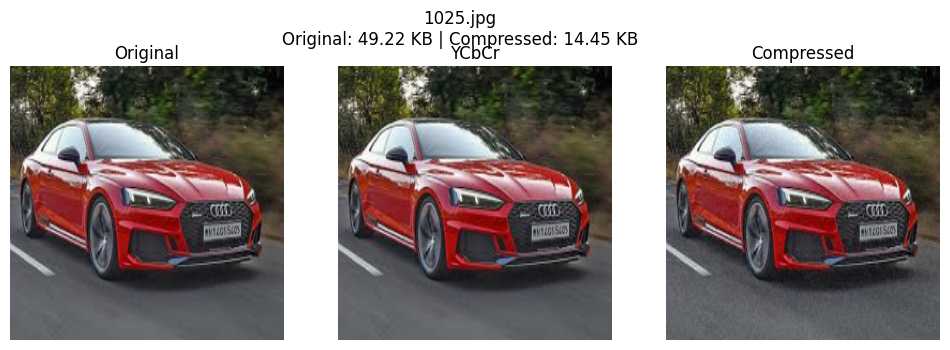

Original size (bytes): 50268
Compressed size (bytes): 13962.38
Compression Ratio: 3.60


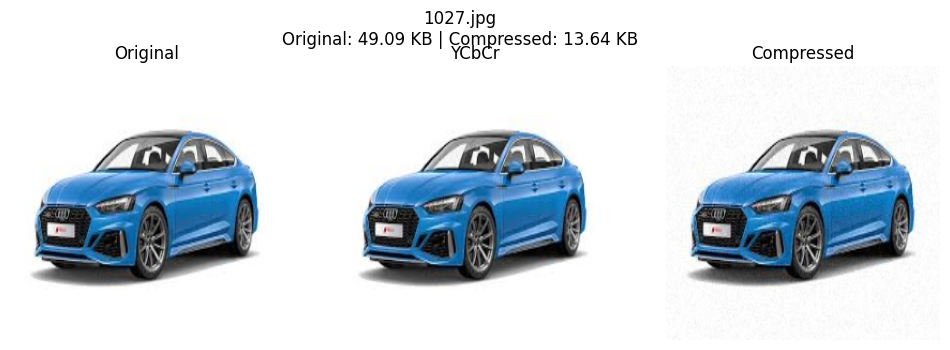

Original size (bytes): 50400
Compressed size (bytes): 11143.75
Compression Ratio: 4.52


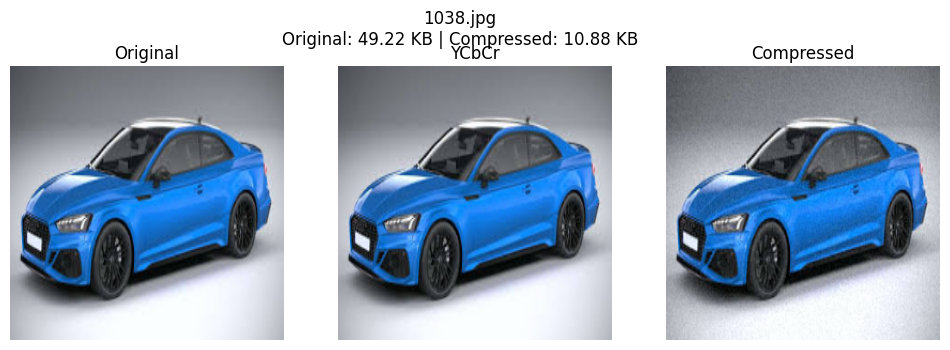

In [10]:

dataset_path = load_dataset()

display_dataset_results(dataset_path, start_index=1, end_index=8)